In [1]:
#Edited: 2025: Sabrina
#Edited 2020: Johannes
# This is an example script for the use of the PointConcentration class/object for pointconcentration measurements
#from the windtunnel python package, showing the use of almost all available analysis functions
# The columns in the input file are expected to be time, wtref, slow FID, fast ID, release signal and open_rate, 
# where release signal will be ignored.
# The PointConcentration class returns a DataFrame, using the standard measurement txt-file output as input

In [3]:
#Path and file names
# Add the parent directory to the path for the windtunnel package import
path_dir = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare"
#Path to your input data
#path = f"{path_dir}/ExampleData/InputData/Concentration/"
#path = f"{path_dir}/ExampleData/InputData/Beispiel Umrechnung zur Kontrolle/"
path = f"/home/sabrina/Schreibtisch/Arbeit_2025/Nora_test/"
# Name of your measurement files prefix
#namelist = ['BFS_BD3_MP01_000']
namelist = ['UBA_thesis'] #['UBA_GA_02_04_01_000_1_001']
#Path to your output folder for average files and plots
output_path = f"{path_dir}/ExampleData/Results/"
SaveOutputFiles=True #Save calculated quantities whole ts 
SaveOutputFilesStats=True #Avg and stats files
os = "Linux"
#For PointData for the functions to work the columns of the file should be: time, wtref, slow_FID, fast_FID, open_rate
#(See manual for the description of the variables)
#Name of csv file which contains ambient conditions data. Multiple diff. ambient conditions for diff datasets can be read-in at ones
#If no file given or configuration wrong, the program ressorts to try reading-in given values manually below. 
#csv_file='ambient_conditions.csv'
#csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions.csv"
#csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions_.UBA_GA.csv"
csv_file= f"{path}ambient_conditions_point1.csv"
parameters_PerFolder = False

#Variables and Parameters set for all ts, if no ambient_conditions.csv file overgiven
#If at the end calculate entdimensionalised or full scale transform quantities
#Default: nd:entdimensionalise, ms:model scale, fs:full scale.    
full_scale='ms'

#Postprocessing before analysis
applyPostprocessing=True
averageInterval=60 #s  #Interval to downaverage raw time series to before analysis
#Overgive uncertainty
uncertainty_value=None #Uncertainty of concentration, has to be calculated/estimated from the experimentator
#If None overgive no error visualized as errorbars 0.5
uncertainty_representation="percentage" #"absoluteValue"

In [5]:
#Example file/Default environment values if no csv_file found:

#Source location  [mm]
x_source=0
y_source=0
z_source=0
#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #0.600#Stickstoffdurchflussregler #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=1.0     #0.3     #0.3 oder 3
calibration_factor=0 #1      #
#Gas characteristics
gas_name='C12'           #Just placeholder name variable for orientation, not used for anything
gas_factor=0.5   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=29.0 #28.97 #Air [g/mol]
#Measurement location [mm]
x_measure=1020 #855.16
y_measure= 0    #176.29
z_measure= 5     #162
#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]
#Model to Reality scaling
scale=400                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/400              #1/250           #Lref
ref_height=100/400            #None            #Href

full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)
#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'

In [6]:
#Imports
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#sys.path.append(os.path.abspath(path_dir))
import windtunnel as wt

###### Initialise concentration ts dictionary of length namelist, as well as for full scale and entdimensionalised
conc_ts = {}
conc_ts.fromkeys(namelist)
conc_ts_fs = conc_ts
conc_ts_nd = conc_ts

dict_conc_ts = conc_ts
dict_conc_nd = conc_ts
dict_conc_fs = conc_ts

data_dict = {}
data_dict.fromkeys(namelist)

#Edited Nora: Check if ambient conditions file is even there, before trying out reading-in
print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)
#Read in ambient conditions for each folder or concentration ts from given csv file or for same conditions from manually
parameters_PerFolder = parameters_PerFolder #False  #True=for each folder/namelist entry new column, False: for each ts one column entry

for name in namelist:
    files = wt.get_files(path, name)
    print(f"files: {files}")

    #Initilise Dictionary for each given name containing dimensions of nr of files ts#0-
    conc_ts[name] = {}
    conc_ts[name].fromkeys(files)
    
    if parameters_PerFolder==True:
        #Read ambient conditions from csv file only for each folder
        ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=name, input_file=csv_file)
        #print(ambient_conditions)
        #Else read/use given default from cell above
        if ambient_conditions is None:
            []
        #Read ambient conditions from csv file
        else:
            x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
            ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure, config_name = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, name)
            
        
    for file in files:
        if parameters_PerFolder == False:
            #Read in ambient condition column for each ts
            ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=file, input_file=csv_file)
            #Else read/use given default from cell above
            if ambient_conditions is None:
                []
            #Read ambient conditions from csv file
            else:
                x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
                ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure,  config_name= wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, file)

        conc_ts[name][file] = wt.PointConcentration.from_file(path + file)
    
        conc_ts[name][file].ambient_conditions(x_source=x_source, y_source=y_source, z_source=z_source,
                                               x_measure=x_measure, y_measure=y_measure, z_measure=z_measure,
                                               pressure=pressure,
                                               temperature=temperature,
                                               calibration_curve=calibration_curve,
                                               mass_flow_controller=mass_flow_controller,
                                               calibration_factor=calibration_factor,
                                               config_name=config_name)

        #Set read-in scaling, gas and full scale information to internal class variables
        conc_ts[name][file].scaling_information(scaling_factor=scaling_factor, 
                                                scale=scale,
                                                ref_length=ref_length, 
                                                ref_height=ref_height)
        conc_ts[name][file].tracer_information(gas_name=gas_name,
                                               mol_weight=mol_weight,
                                               gas_factor=gas_factor)
        conc_ts[name][file].full_scale_information(full_scale_wtref=full_scale_wtref,
                                                   full_scale_flow_rate=full_scale_flow_rate,
                                                   full_scale_temp=full_scale_temp,full_scale_pressure=full_scale_pressure)

        #Calculate mass flow rate, net concentration and dimensionalise concentration
        conc_ts[name][file].convert_temperature()
        conc_ts[name][file].calc_wtref_mean()
        
        conc_ts[name][file].calc_model_mass_flow_rate(usingMaxFlowRate="True",applyCalibration="False")
        conc_ts[name][file].calc_net_concentration()

        #conc_ts[name][file].clear_zeros()  #Remove values net_concentration =< 0 from dataset !noise
        conc_ts[name][file].calc_c_star()

        conc_ts[name][file].calc_full_scale_concentration() #Try


                #Test net_conc and c*star output
        if hasattr(conc_ts[name][file], "concentration"):
            if hasattr(conc_ts[name][file], "net_concentration"):
                setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)
            else:
                print("⚠️ Kein concentration oder net_concentration gefunden.")
        
        
        if hasattr(conc_ts[name][file], "c_star"):
            print("c_star vorhanden")
        else:
            print("⚠️ Keine c_star Daten gefunden.")


#Options for Outputting data in full-scale, model scale, and non-dimensionally.
        if full_scale == 'ms':
            dict_conc_ts = conc_ts
            
        elif full_scale == 'fs':
            dict_conc_ts = conc_ts_fs
            dict_conc_ts[name][file].to_full_scale()
            
        elif full_scale == 'nd':
            dict_conc_ts = conc_ts_nd
            dict_conc_ts[name][file].to_non_dimensional()
        else:
            print(
                "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
        

#Saving PointConcObject calculates new quantities(f.e. c*star), avg and stats and combined files to outputPath
        if(SaveOutputFiles==True):
            if os=="Windows":
            folder = 'Point_Data\\' + name[:name.find('.')] + '\\'
            elif os=="Linux":
             folder = 'Files/' + 'Point_Data/' + name[:name.find('.')] + '/'
        
            wt.check_directory(output_path + folder)
            dict_conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].__check_sum = 8
            #dict_conc_ts[name][file].__check_sum = 8
            if full_scale == 'ms':
                dict_conc_ts[name][file].save2file_ms(file, out_dir=output_path + folder)
            elif full_scale == 'fs':
                dict_conc_ts[name][file].save2file_fs(file, out_dir=output_path + folder)
            elif full_scale == 'nd':
                dict_conc_ts[name][file].save2file_nd(file, out_dir=output_path + folder)
            else:
                print(
                    "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")

            #Saving averages and stats to files under folder Point_Data_avg/Point_Data_stats
        if(SaveOutputFilesStats==True):
            if os=="Windows":
                folder_avg = 'Point_Data_avg\\' + name[:name.find('.')] + '\\'
                folder_stats = 'Point_Data_stats\\' + name[:name.find('.')] + '\\'
            elif os=="Linux":
                folder_avg = 'Files/' + 'Point_Data_avg/' + name[:name.find('.')] + '/'
                folder_stats = 'Files/' + 'Point_Data_stats/' + name[:name.find('.')] + '/'
            
            #Stats Full ausgabe: Mean, percentile 95, percentile 5, peak2Mean  
                    wt.check_directory(output_path + folder_avg)
                    wt.check_directory(output_path + folder_stats)
                    dict_conc_ts[name][file].save2file_avg(file, out_dir=output_path + folder_avg)
                    dict_conc_ts[name][file].save2file_fullStats(file, out_dir=output_path + folder_stats)  

#wdir,0,5

{'UBA_thesis': None}

c_star vorhanden
0        0.009237
1        0.007575
2        0.002317
3        0.004413
4        0.022444
           ...   
29995    0.071216
29996    0.068533
29997    0.027061
29998    0.009583
29999    0.007594
Length: 30000, dtype: float64
0         41.191695
1         33.780976
2         10.335209
3         19.679733
4        100.091478
            ...    
29995    317.597066
29996    305.635021
29997    120.681723
29998     42.738688
29999     33.866465
Length: 30000, dtype: float64
0         766.950587
1         628.969975
2         192.431863
3         366.418104
4        1863.609103
            ...     
29995    5913.358412
29996    5690.636394
29997    2246.980084
29998     795.754140
29999     630.561700
Length: 30000, dtype: float64
0.014318096117579187
63.853763805999996
0.013496670158937817
71.17889333373333


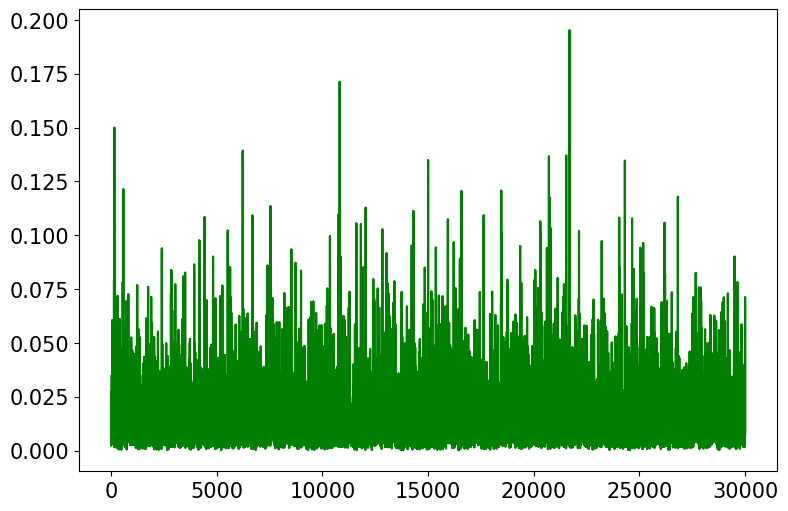

In [23]:

#Test numerical value range
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].c_star)
#Test full scale trafo numerical value range
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].full_scale_concentration)
#Test numerical value means
print(np.mean(conc_ts[name][files[0]].c_star))
print(np.mean(conc_ts[name][files[0]].net_concentration))
print(np.mean(conc_ts[name][files[1]].c_star))
print(np.mean(conc_ts[name][files[1]].net_concentration))
#Test ts shape
c = ["green"]
i=0
for file in files:
    #plt.figure()
    plt.plot(conc_ts[namelist[0]][files[0]].c_star,color=c[i])
    #plt.legend(["test"])
plt.show()

In [24]:
print(conc_ts[name][file].concentration)
print("Shape:", conc_ts[name][file].concentration.shape)
print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].concentration)))
print("Min/Max:", np.min(conc_ts[name][file].concentration), "/", np.max(conc_ts[name][file].concentration))
for name in namelist:
    for file in files:
        print(conc_ts[name][file].calc_percentiles(percentiles=[10, 90, 95], var='net_concentration'))
        #print(np.mean(conc_ts[name][file].net_concentration))
        #print(np.std(conc_ts[name][file].net_concentration))

AttributeError: 'PointConcentration' object has no attribute 'concentration'

In [26]:
#Postprocessing if overgiven
"""
measurementFreq=0.005 #Time series frequency #For now only for static case implemented
averageInterval=averageInterval #60 #s
columns=["net_concentration"] #Columns to average down

print(len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))]))
#print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)
if(applyPostprocessing==True):
    for name in namelist:
        for file in files:
            dict_conc_ts[name][file].downAverage(averageInterval=averageInterval,measurementFreq=measurementFreq, columns=columns)
            #dict_conc_ts[name][file].net_concentration

print(len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))
"""

'\nmeasurementFreq=0.005 #Time series frequency #For now only for static case implemented\naverageInterval=averageInterval #60 #s\ncolumns=["net_concentration"] #Columns to average down\n\nprint(len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))]))\n#print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)\nif(applyPostprocessing==True):\n    for name in namelist:\n        for file in files:\n            dict_conc_ts[name][file].downAverage(averageInterval=averageInterval,measurementFreq=measurementFreq, columns=columns)\n            #dict_conc_ts[name][file].net_concentration\n\nprint(len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))\n'

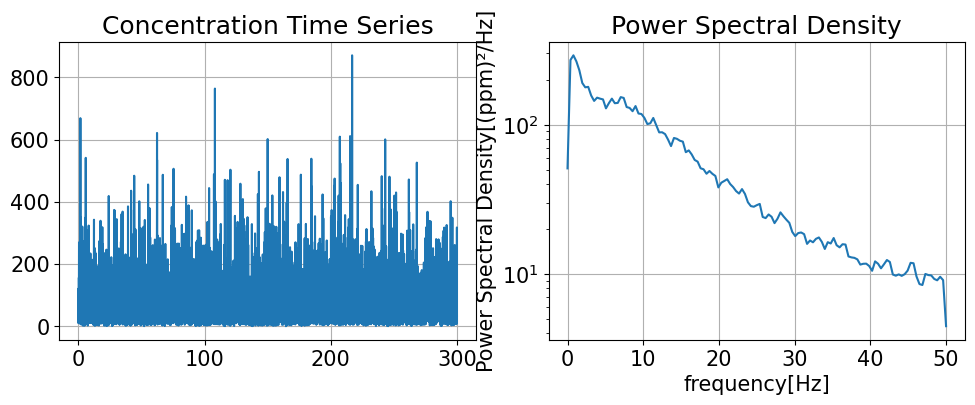

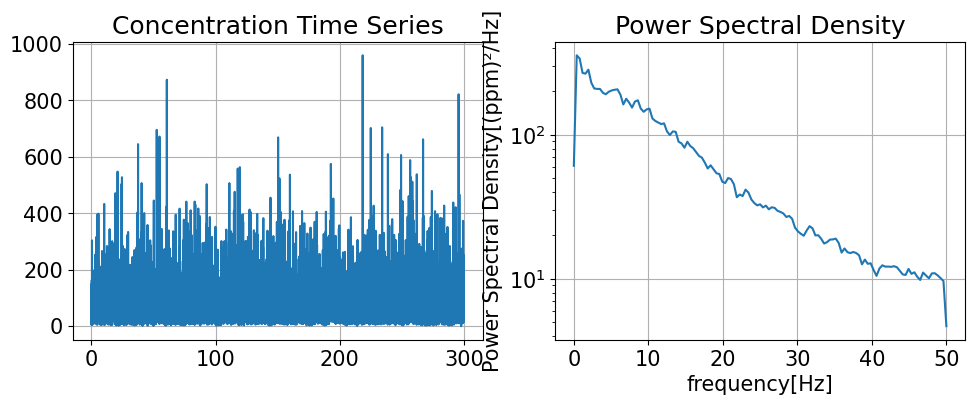

In [30]:
#Concentration fluctuation analysis 
#Intermittency based on threshold, peak2Mean, concentration variance spectral density distribution

#Seettings intermittency calculation
threshold_type="ratio" #ratio, absolute
threshold_method="mean" #mean, std
intermittency_threshold=1.5 #-> if type=ratio,method mean, threshold=threshold*mean(concentration), if type=absolute: threshold=threshold

for name in namelist:
    for file in files:
        conc_ts[name][file].analyze_concentration_fluctuations(dimensionless="False",
                                                       intermittency_threshold=intermittency_threshold,threshold_method=threshold_method)
#power(variance) of concentration changes for different frequencies/timer interval lengths 
#Low-frequency peak: Slow, gradual concentration changes
#High-frequency peak: Rapid, quick concentration fluctuations
#Broad spectrum: Mixed or complex concentration dynamics

In [31]:
#For completeness also calculate further characteristic metrics of flow/ wind velocity time series (from wtref ts), skewness ..
#print(conc_ts[name][file].calculate_turbulence_intensity(dimensionless="True",returnDistribution="False",returnMetrics="True"))

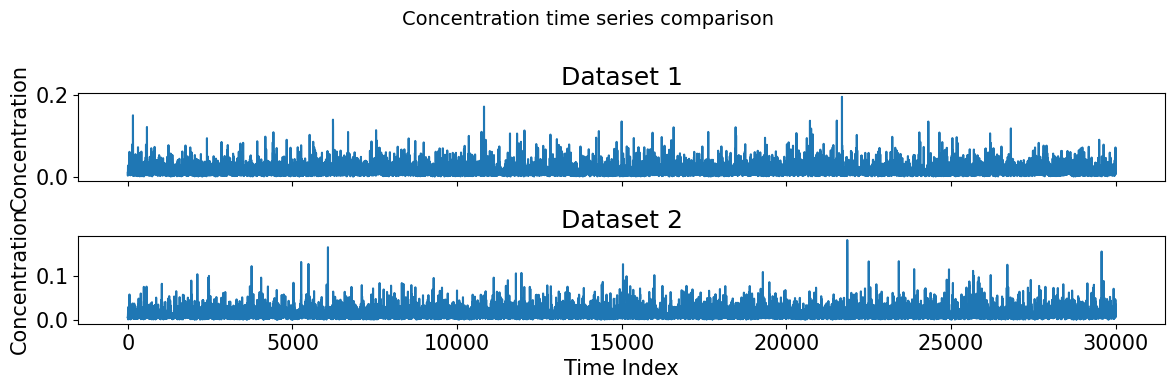

matplotlib.legend: WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1 2]
2
3
[array([ 0.      ,  0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,
        2.34375 ,  2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,
        4.6875  ,  5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,
        7.03125 ,  7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,
        9.375   ,  9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125,
       11.71875 , 12.109375, 12.5     , 12.890625, 13.28125 , 13.671875,
       14.0625  , 14.453125, 14.84375 , 15.234375, 15.625   , 16.015625,
       16.40625 , 16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375,
       18.75    , 19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125,
       21.09375 , 21.484375, 21.875   , 22.265625, 22.65625 , 23.046875,
       23.4375  , 23.828125, 24.21875 , 24.609375, 25.      , 25.390625,
       25.78125 , 26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375,
       28.125   , 28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125,
       30.46875 , 30.859375, 31.25    , 

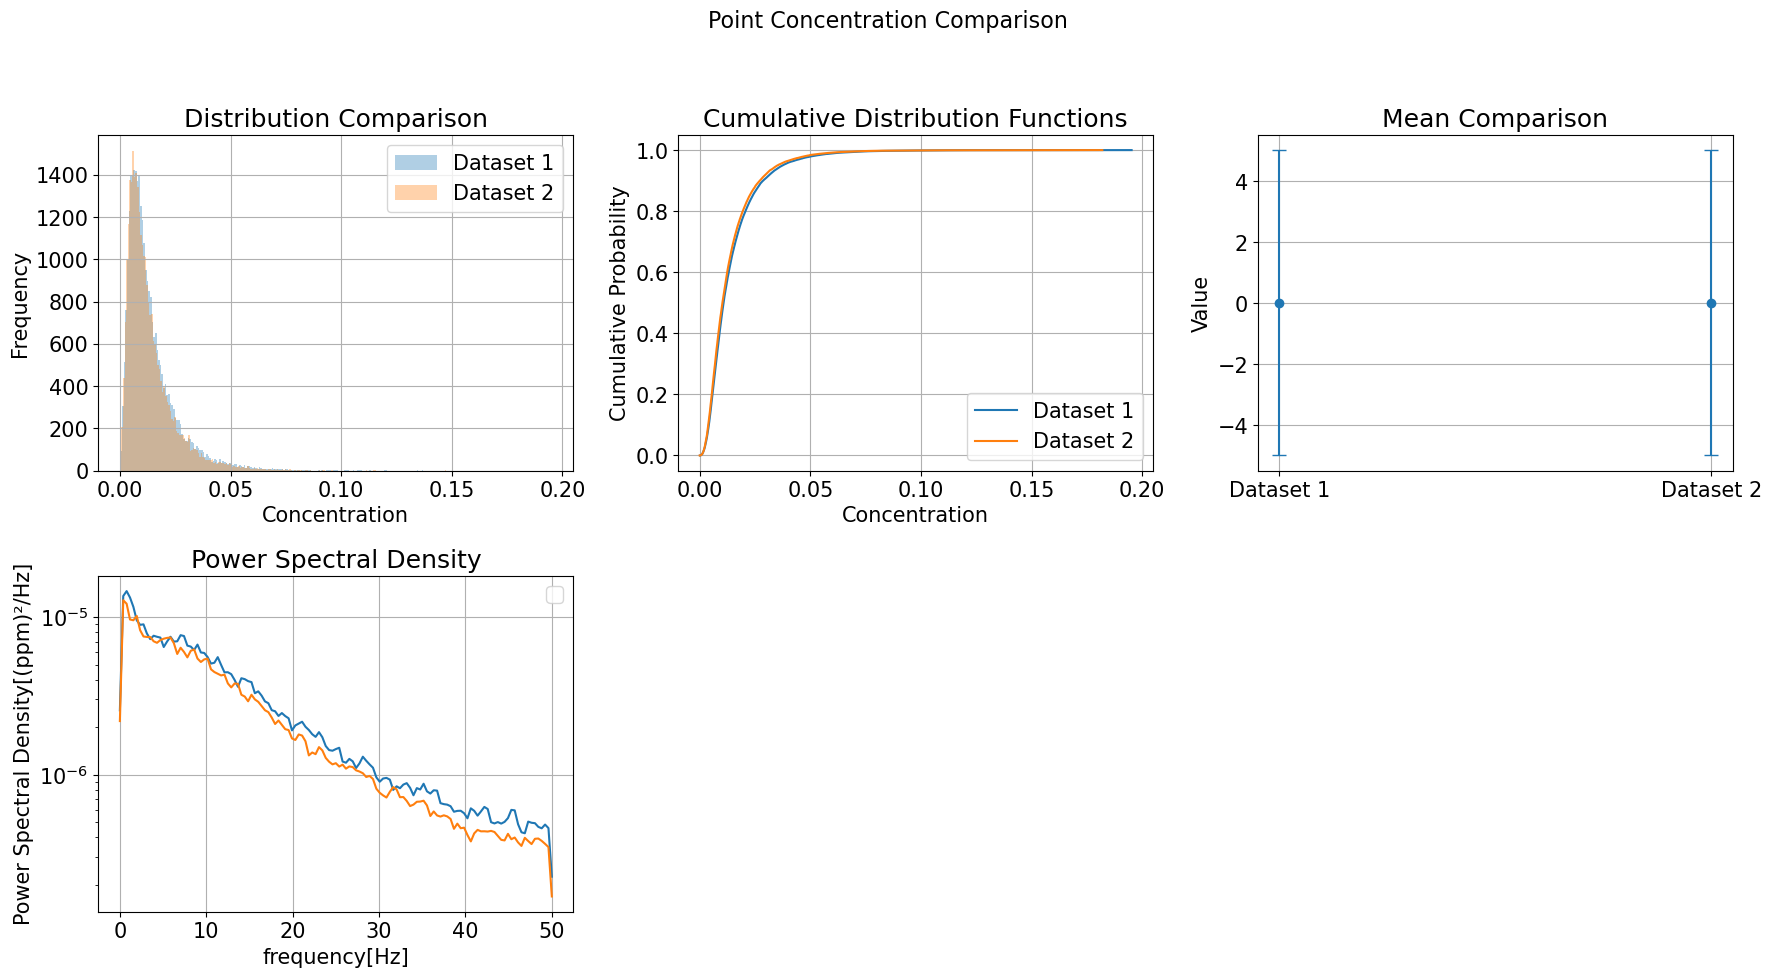


Detailed Comparison:
Mean: Dataset 1 = 0.0143, Dataset 2 = 0.0135
Std Dev: Dataset 1 = 0.0123, Dataset 2 = 0.0116
Skewness: Dataset 1 = 2.7365, Dataset 2 = 2.8395
Percentile 95: Dataset 1 = 0.0374, Dataset 2 = 0.0351
Turbulence Intensity v: Dataset 1 = 0.0083, Dataset 2 = 0.0073
Turbulence Intensity c: Dataset 1 = 0.8572, Dataset 2 = 0.8567
Pearson r (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0055
Spearman rho (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = -0.0011
RMSE (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0168


In [32]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..

#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]
    
functionsForOverview = [
    "Histogram",
    "BoxPlot"
    #"",
    "Pdf",
    "Cdf",
    "Means",
    "PowerDensity"
        ]

#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]][files[0]],#
    conc_ts[namelist[0]][files[1]],
    #conc_ts[namelist[0]][files[2]],
    #conc_ts[namelist[0]][files[3]],
    #conc_ts[namelist[0]][files[4]],
    #conc_ts[namelist[0]][files[5]]
]

compare_point_concentrations_3(DataPointsConc,functionsForOverview)

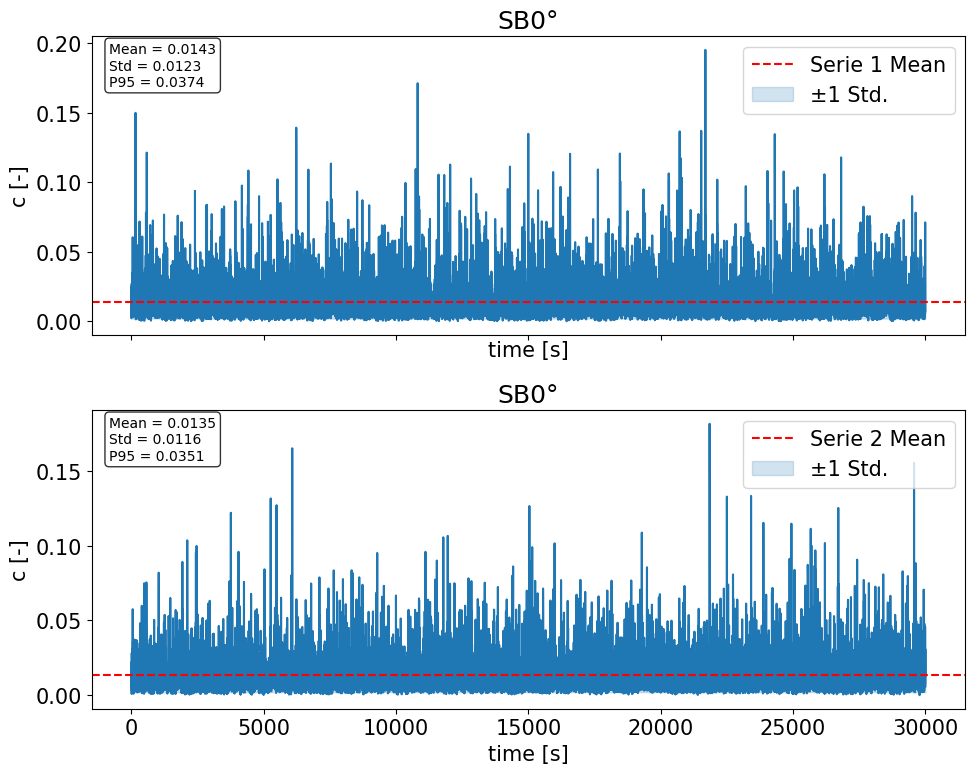

In [33]:
def plot_timeseries_with_stats(ax, ts_data, label, color):
    title = ts_data.config_name
    series = ts_data.c_star
    mean_val = np.mean(series)
    std_val = np.std(series)
    p95_val = np.percentile(series, 95)
    
    # Zeitserie
    ax.plot(series, color=color)
    
    # Mittelwertlinie
    ax.axhline(mean_val, color="red", linestyle="--", label=f"{label} Mean")
    
    # ±1 Std.-Bereich
    ax.fill_between(range(len(series)), mean_val - std_val, mean_val + std_val, 
                    color=color, alpha=0.2, label="±1 Std.")
    
    # Textbox mit Stats
    textstr = f"Mean = {mean_val:.4f}\nStd = {std_val:.4f}\nP95 = {p95_val:.4f}"
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    ax.set_xlabel("time [s]")
    ax.set_ylabel("c [-]")
    ax.set_title(title)
    ax.legend(loc="upper right")

# Richtige Zeitserien laden
ts1 = conc_ts[namelist[0]][files[0]]
ts2 = conc_ts[namelist[0]][files[1]]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

plot_timeseries_with_stats(axes[0], ts1, "Serie 1", "tab:blue")
plot_timeseries_with_stats(axes[1], ts2, "Serie 2", "tab:blue")

plt.tight_layout()
plt.show()


[103.89648858333334, 23.038903871666676, 6.4709915363333295, 3.7430403243333217, 1.291780661333327]
[97.76765013333332, 27.259735805000005, 9.619464627666673, 8.762905275000008, 2.985935848166676]


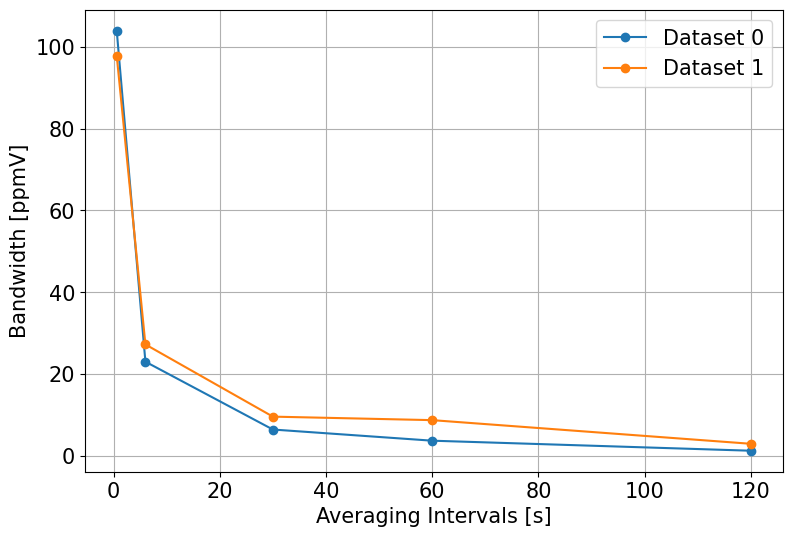

In [114]:
#Bandwidth convergence plot
xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
Labels = None
dimensionless = False
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'
#colors = ["green",""blue"]
time_freq = 0.010 #s
averaging_intervals = [60*0.01,60*0.1,60*0.5,60*1.0,60*2.0]# [60*0.01,60*0.1,60*0.5, 60*1,60*2,60*3,60*4,60*5]#in s     #Example for [15,30 and 60 min]
#t*[[-] =[s/(m/s) * m]  = t[s] / Uref[m/s] * Lref[m]


def get_averagedData(name, filename, time_freq, averaging_intervals):    
    data = conc_ts[name][filename]
    data = data.c_star if dimensionless else data.net_concentration
    data = data.values  #pandas Series to numpy array
    
    splits = [int(averaging_interval / time_freq) for averaging_interval in averaging_intervals]
    v_averages = []
    for split in splits:
        trimmed_length = len(data) // split * split #Trim data to be divisible by split size
        #print(len(data))
        #print(trimmed_length)
        trimmed_data = data[:trimmed_length]
        #print(len(trimmed_data))
        averages = np.mean(trimmed_data.reshape(-1, split), axis=1) #Average along axis=1
        v_averages.append(averages)
    return v_averages
    
bandwidths = []
for name in namelist:
    for filename in files:
        ts_v_avg = get_averagedData(name, filename, time_freq, averaging_intervals)
        bandwidths.append([np.max(avg) - np.min(avg) for avg in ts_v_avg])  # or use np.ptp(avg)(peakTopeak) for same result, but faster

for i, bandwidth in enumerate(bandwidths):
    print(bandwidth)
    plt.plot(averaging_intervals, bandwidth, "o-", 
             label=f"Dataset {i}" if Labels is None else Labels[i])
plt.xlabel("Averaging Intervals [s]")
plt.ylabel("Bandwidth [ppmV]")
plt.legend()
plt.grid(True)
plt.show()

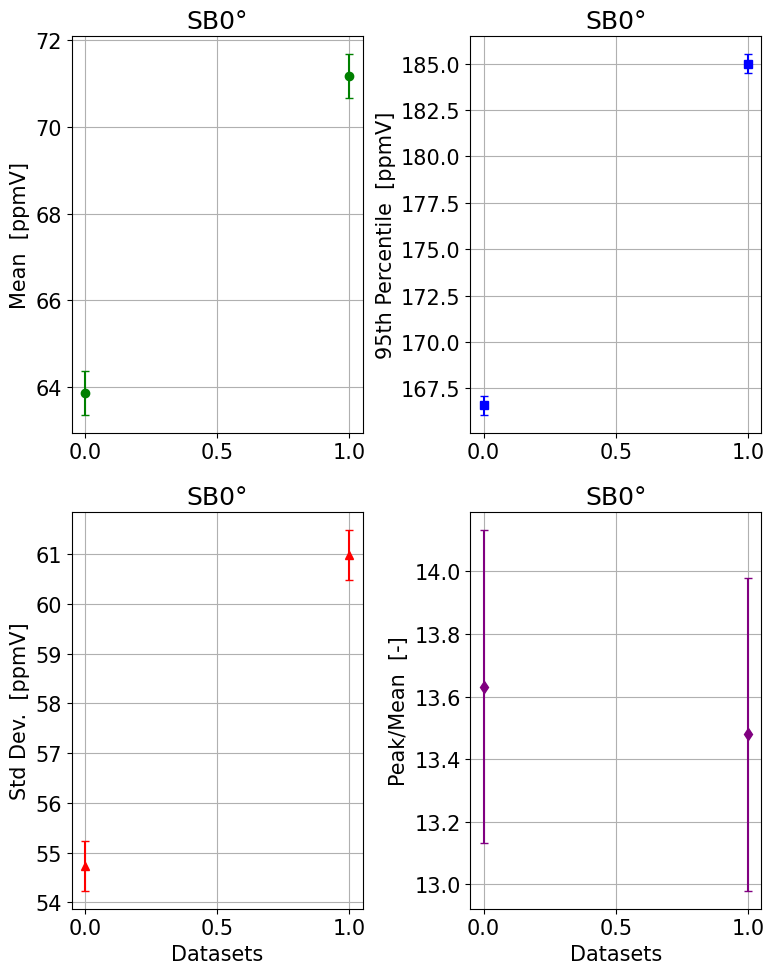

In [34]:
#4x1 Table means, std., peak2mean,percentile 
xLabels = "Datasets"
yLabels = ['Mean  [ppmV]', '95th Percentile  [ppmV]', 'Std Dev.  [ppmV]','Peak/Mean  [-]'] #None #"Concentration"
Labels = None
dimensionless = False
xAchse = None
yAchse = None
markers = ['o', 's', '^', 'd']
colors = ["green","blue","red","purple"]

error_values = 0.5 #[error_mean,error_95,error_std,error_peak/mean]
percentileValue = 95 #percentil for percentilCalculation 95->95%

# Extract data
DataPointsConc2 = []
for i in range(len(files)):
    data = conc_ts[namelist[0]][files[i]]
    DataPointsConc2.append(data.c_star if dimensionless else data.net_concentration)

# Calculate stats
x = range(len(DataPointsConc))
stats = [[np.mean(d),  np.percentile(d, percentileValue), np.std(d),np.max(d)/np.mean(d)] for d in DataPointsConc2]
stats = list(zip(*stats))
errors = error_values if isinstance(error_values, list) else [error_values] * len(DataPointsConc)

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
axes_flat = axes.flatten()  # Convert 2x2 array to 1D array

for i, ax in enumerate(axes_flat):
    ax.errorbar(x, stats[i], yerr=errors, fmt=markers[i], capsize=3, color=colors[i])
    if yAchse: 
        ax.set_ylim(yAchse)
    if xAchse: 
        ax.set_xlim(xAchse)
    if i >= 2:  # Bottom row subplots
        ax.set_xlabel(xLabels)
    ax.set_ylabel(yLabels[i])
    ax.grid(True)   
    ax.set_title(data.config_name)
    # ax.set_xticks(x)
    # ax.set_xticklabels([f'Dataset {j+1}' for j in x])

plt.tight_layout()
if Labels != None:
    plt.legend(Labels)
plt.show()

In [35]:
#Start visualisation single plots, adjustable
#ReadIn/Choose data (PointObjects) from the analysis above, to use for the separat plot visualisations, import plotting functions

#Specify files
#DataPointsConc = [
#    conc_ts[namelist[0]]Line2D[files[0]],
#    conc_ts[namelist[0]][files[1]]
#]
#All files read-in
DataPointsConc=[]
for i in range(0,len(files)):
    DataPointsConc.append(
        conc_ts[namelist[0]][files[i]]
    )
#Labels    
labels = [f"Dataset {i}" for i in range(1,len(DataPointsConc)+1)]

print(labels)
print(DataPointsConc)

#Load all functions for plotting
from windtunnel.concentration.CompareDatasets import *

['Dataset 1', 'Dataset 2']
[PointConcentration (x=50.0, y=0.0, z=10.0), PointConcentration (x=50.0, y=0.0, z=10.0)]


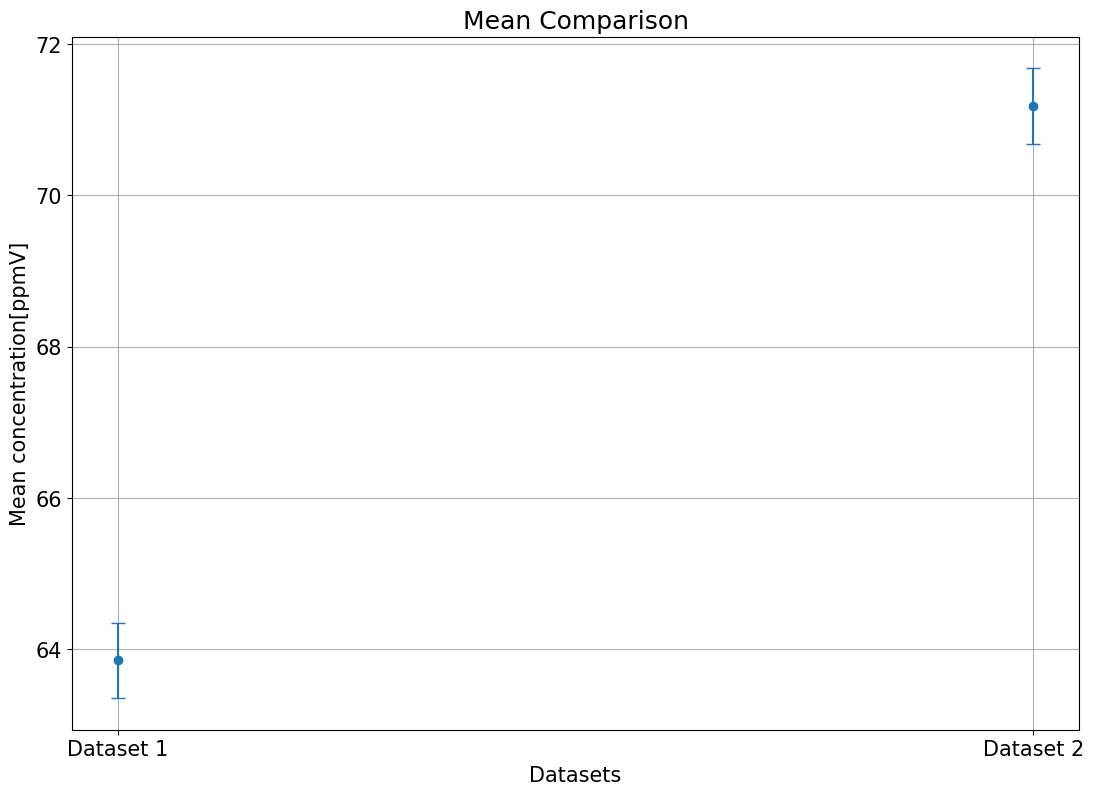

In [36]:
xLabel="Datasets"
yLabel="Mean concentration[ppmV]" 
dimensionless="False"
xAchse = None 
yAchse=None #(72,79) #None 
error_values=0.5 #[0.5,0.2,0.1] #For error values overgive one number which is cast to all values, or an array if specify different errors for each measurements
errorType="absolute"
test = create_means(DataPointsConc,error_values,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse)
#plt.savefig("Mean_comparison.png",test) #To save image


In [ ]:
xLabel="Concentration[-]"
yLabel="Density"
dimensionless="True"
create_pdf(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

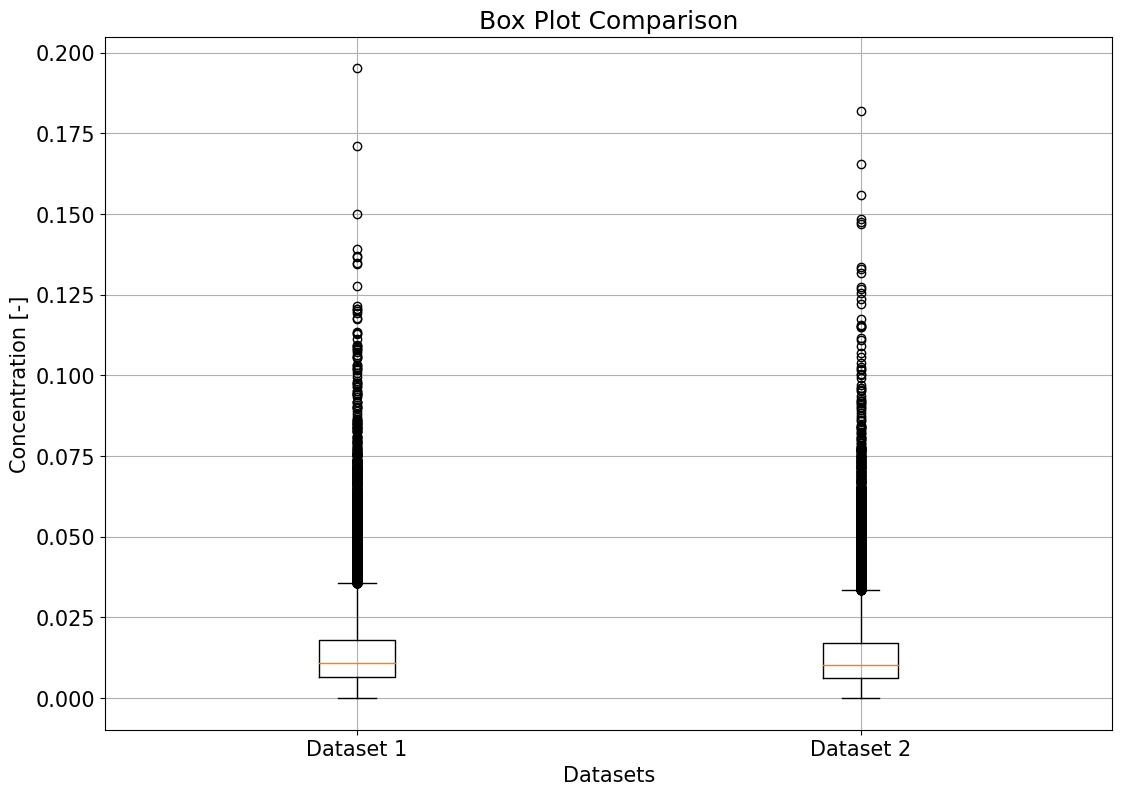

In [73]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_boxplot(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
xLabel="Datasets"
yLabel="Concentration[ppmV]"
xLabel="Datasets"
yLabel="Concentration[ppmV]"
create_histogram(DataPointsConc,dimensionless="False",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
yLabel=None
xLabel="Concentration[-]"
dimensionless="False"
create_cdf(DataPointsConc,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
test = powerDensityPlot(DataPointsConc,dimensionless="False",plot=True,labels=None,xLabel=None,yLabel=None,xAchse=None,yAchse=None)
plt.savefig("test.png",test)

In [ ]:
#full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
base_path = output_path + "Files/Point_Data_avg/UBA_thesi/"
file_names = ["_avg_" + file for file in files]
for file in file_names:
    #metadata = {}
    data = []
    with open(full_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith('"'):
                # Kopfzeile mit Variablennamen
                headers = line.replace('"', '').split()
                continue
            # Wertezeile
            values = list(map(float, line.split()))
            data.append(values)
    
    df = pd.DataFrame(data, columns=headers)
    print(df.head())

In [ ]:
#from windtunnel.concentration.utils import batch_combine_data, load_combined_data_from_csv

from windtunnel.concentration.utils import *
#normal test
file_names = ["_stats_" + file for file in files]
#stats test
#file_names = [
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#2",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#3",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#4",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#5"
#]
#base_path =output_path
#base_path = output_path + "Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00"
#base_path = output_path + "Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/"
base_path = output_path + "Files/Point_Data_stats/UBA_thesi/"
#combine_to_csv(file_names, base_path, file_type='avg', output_filename=output_path+'combined_data.csv')
combine_to_csv(file_names, base_path, file_type='stats', output_filename=output_path+'combined_data_nora.csv')



In [ ]:
import matplotlib.patches as mpatches  # Änderungen: Alias für patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import *
from windtunnel.concentration.utils import load_csv

#Daten einlesen
readFromCsv=True #If False overgive through punkte = [(x,y,z,c),..] manually
path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/Building_plots/Python code/messpunkte_1.csv"
path2 = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data.csv"

#Bebauung auswählen
#number_houses,houses_spacing_btw,triangle_points,x0 = 1,0,np.array([[-5, 4.23],[5, 4.23],[0, 7.118]]),-5                #Bebauung 1
#number_houses,houses_spacing_btw,triangle_points,x0 = 9,10,np.array([[-85, 4.23],[-75, 4.23],[-80, 7.118]]),-85        #Bebauung 2
#number_houses,houses_spacing_btw,triangle_points,x0 = 7,20,np.array([[-95, 4.23],[-85, 4.23],[-90, 7.118]]),-95        #Bebauung 3
#number_houses,houses_spacing_btw,triangle_points,x0 = 5,40,np.array([[-105, 4.23],[-95, 4.23],[-100, 7.118]]),-105     #Bebaunng 4
number_houses,houses_spacing_btw,triangle_points,x0 = 6,[15,20],np.array([[-90, 4.23],[-80, 4.23],[-85, 7.118]]),-90    #Bebaunng 5

# Bereiche und Meter pro Kästchen festlegen, Bleibt eigentlich überall gleich
x_min, x_max = -110, 110 #-50,50 #-10, 110
z_min, z_max = 0, 40
spacing = 5  # Abstand zwischen Linien/Kästchen
z0 = 0
#Settings für alle Häuser
rect_width = 10  # von -5 bis 5
rect_height = 4.23

#Settings for colorbar and figure
# --- Color coding and thresholds ---
thresholds = [0, 1]  # lower and upper thresholds (exclusive)
cmap = plt.cm.RdBu   # colormap for intermediate values
cmap = cmap.reversed()
figSize = (20,8)

#Messpunkte einlesen
if(readFromCsv==True):
    points,values= load_csv(path)
    punkte = [(points[i][0],points[i][1],points[i][2],values[i]) for i in range(0,len(points))]


#Anzahl Spacing zwischen häusern und Häuseranzahl
if(isinstance(houses_spacing_btw,list)):
    houses_spacing = [0,0]
    houses_spacing[0] = 10 + houses_spacing_btw[0] #10#20 #Abstand zwischen Häuserkanten (Mittelpunkte Häuser + Abstand)
    houses_spacing[1] = 10 + houses_spacing_btw[1] #10#20 #Abstand zwischen Häuserkanten (Mittelpunkte Häuser + Abstand)

else:
    houses_spacing = 10 + houses_spacing_btw #10#20 #Abstand zwischen Häuserkanten (Mittelpunkte Häuser + Abstand)

# Linienanzahl berechnen
x_lines = int(np.ceil((x_max - x_min) / spacing))
z_lines = int(np.ceil((z_max - z_min) / spacing))
# Erstellen der Figur und Achse
fig, ax = plt.subplots(figsize=figSize)
# Gitterlinien für X-Z Ebene
for i in range(x_lines + 1):
    x = x_min + i * spacing
    ax.plot([x, x], [z_min, z_max], color='gray', linewidth=0.5)
for j in range(z_lines + 1):
    z = z_min + j * spacing
    ax.plot([x_min, x_max], [z, z], color='gray', linewidth=0.5)

for i in range(0,number_houses):   
    #Rechteck
    rect = plt.Rectangle((x0, z0), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)
    #Dreieck fürs Dach
    triangle = plt.Polygon(triangle_points, closed=True, color='black')
    ax.add_patch(triangle)
    #Update to next position
    #Bebauung 5
    if(isinstance(houses_spacing_btw,list)):
        print(i%2)
        x0=x0 + houses_spacing[(i+1)%2] #Rechteck
        triangle_points[0][0] = triangle_points[0][0] + houses_spacing[(i+1)%2]
        triangle_points[1][0] = triangle_points[1][0] + houses_spacing[(i+1)%2]
        triangle_points[2][0] = triangle_points[2][0] + houses_spacing[(i+1)%2]
    #Alle anderen
    else:
        x0=x0 + houses_spacing #Rechteck
        triangle_points[0][0] = triangle_points[0][0] + houses_spacing #Dach
        triangle_points[1][0] = triangle_points[1][0] + houses_spacing
        triangle_points[2][0] = triangle_points[2][0] + houses_spacing


# Nur Punkte mit y=0 für Horizontal
punkte_y0 = [p for p in punkte if p[1] == 0]
# Farbzuordnungsfunktion
def get_color(c):
    if c > 9:
        return 'red'
    elif c < 1:
        return 'blue'
    else:
        ratio = (c - 1) / 8
        return plt.cm.RdBu(ratio)  # Korrekte Nutzung der colormap

# Punkte plotten
for (x, y, z, c) in punkte_y0:
    if x_min <= x <= x_max and z_min <= z <= z_max:
        color = get_color(c)
        ax.plot(x, z, 'o', color=color, markersize=12)
        ax.text(x + 1.5, z, f'{c:.1f}', fontsize=8, verticalalignment='center')
# Achsenanpassung
ax.set_xlim(x_min, x_max)
ax.set_ylim(z_min, z_max)
ax.set_aspect('equal')
#ax.axhline(0, color='blue', linewidth=1)
#ax.axvline(0, color='blue', linewidth=1)
ax.set_xlabel('x[m]')
ax.set_ylabel('z [m]')
ax.set_title(f'GA House spacing: {houses_spacing_btw}m')
ax.grid(False)
# --- Legend ---
red_patch = mpatches.Patch(color='red', label=f'c > {thresholds[1]}')
blue_patch = mpatches.Patch(color='blue', label=f'c < {thresholds[0]}')
plt.legend(loc="upper left",handles=[red_patch, blue_patch],fontsize=10)
# --- Colorbar---
norm = BoundaryNorm([float('-inf'), thresholds[0], thresholds[1], float('inf')], cmap.N)
sm = ScalarMappable(norm=plt.Normalize(thresholds[0], thresholds[1]), cmap=cmap)
divider = make_axes_locatable(ax)
colorbar_axes = divider.append_axes("right",size="5%",pad=0.1)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical',cax=colorbar_axes)
cbar.set_label('c*[-]')

plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 25 20:38:09 2025

@author: knarf
"""
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib as mpl

# Bereiche
x_min, x_max = -10, 110
y_min, y_max = -30, 30
spacing = 5

# Gitterlinien zeichnen
fig, ax = plt.subplots(figsize=(14, 8))
for x in np.arange(x_min, x_max + spacing, spacing):
    ax.plot([x, x], [y_min, y_max], color='gray', linewidth=0.5)
for y in np.arange(y_min, y_max + spacing, spacing):
    ax.plot([x_min, x_max], [y, y], color='gray', linewidth=0.5)

# Funktion zum Hinzufügen von schwarzen Rechtecken
def add_black_rectangle(x, y, width=10, height=10):
    rect = plt.Rectangle((x, y), width, height, color='black')
    ax.add_patch(rect)

# Ursprüngliche schwarzen Felder: 15x15 Meter im Ursprung (0,0)
# Position des 15x15 Rechtecks im Koordinatenursprung
orig_rect_x = -10/2  # Mitte bei 0,0, also x= -7.5
orig_rect_y = -10/2  # y= -7.5
add_black_rectangle(orig_rect_x, orig_rect_y, width=10, height=10)

# Neue schwarze Rechtecke an verschiedenen Positionen (Beispiele)
positions = [
    (15, 5),
    (-5, 15),
    (-5, -25),
    (15, -15),
    (15, -35),
    (15, 25),
    (35, 15),
    (35, -5),
    (35, -25),
    (55, -15),
    (55, -35),
    (55, 5),
    (55, 25),
    (75, 15),
    (75, -5),
    (75, -25),
    (95, -35),
    (95, -15),
    (95, 5),
    (95, 25),
]
for (x, y) in positions:
    add_black_rectangle(x, y, width=10, height=10)

# Punkt-Daten, unverändert
punkte = [(50, 0, 2, 8.0811129906061),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (50, 15, 2, 3.92475487135893),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (7.5, 0, 2, 6.65164122168862),
    (10, 0, 2, 6.19026498307227),
    (12.5, 0, 2, 5.52762603635695),
    (15, 0, 2, 5.70030368873425),
    (17.5, 0, 2, 6.77501508465002),
    (20, 0, 2, 8.12403269141749),
    (25, 0, 2, 11.2717136599455),
    (30, 0, 2, 12.8241234543974),
    (50, 0, 2, 7.94929705114026),
    (100, 0, 2, 4.37599132679174),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (10, 0, 2, 6.31608275524858),
    (0, 0, 0, None),
    (0, 0, 0, None),
    (10, 0, 8, 103.966727648895),
    (10, 0, 10, 61.4747608231652),
    (10, 0, 12, 13.0625260357662),
    (50, 0, 2, 8.00066851578678),
    (50, 0, 6, 8.93534732089732),
    (50, 0, 10, 8.8437081644944),
    (50, 0, 14, 4.6896995238657),
    (50, 0, 18, 1.55370375595117),
    (50, 0, 22, 0.289574204549816),
    (0, 0, 0, None),
    (10, 2, 2, 4.83596903950623),
    (10, 4, 2, 2.21680368728491),
    (10, 6, 2, 0.607257632042779),
    (10, 8, 2, 0.30905131154923),
    (10, 10, 2, 0.167295110283912),
    (10, -4, 2, 1.67384774886721),
    (10, -8, 2, 0.217813358173836),
    (25, 0, 1, 10.0849212843813),
    (25, 0, 2, 11.1308819551518),
    (25, 0, 4, 15.8138029246341),
    (25, 0, 8, 21.3538836795309),
    (25, 0, 12, 12.8776130259445),
    (25, 0, 16, 1.91348999012856),]

# Punkte filtern
gefilterte_punkte_z2 = [p for p in punkte if p[2] == 2]
# Farbenfunktion
def get_color(c):
    if c > 9:
        return 'red'
    elif c < 1:
        return 'blue'
    else:
        ratio = (c - 1) / (9 - 1)
        return plt.cm.RdBu(1 - ratio)

# Plotten mit Beschriftung der Konzentration
for (x, y, z, c) in gefilterte_punkte_z2:
    if x_min <= x <= x_max and y >= y_min and y <= y_max:
        color = get_color(c)
        ax.plot(x, y, 'o', color=color, markersize=12)
        # Konzentration mit einer Nachkommastelle anzeigen
        ax.text(x + 0.5, y, f'{c:.1f}', fontsize=8, verticalalignment='center')

# Achsen & Legende
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axhline(0, color='blue', linewidth=1)
ax.axvline(0, color='blue', linewidth=1)
ax.set_xlabel('X-Achse (Meter)')
ax.set_ylabel('Y-Achse (Meter)')
ax.set_title('Nur Punkte mit z=2 (Konzentration mit 1 Nachkommastelle)')
ax.grid(False)

# Legende für Farben
red_patch = mpatches.Patch(color='red', label='c > 9')
blue_patch = mpatches.Patch(color='blue', label='c < 1')
plt.legend(handles=[red_patch, blue_patch])

# Rotes Kreuz im Koordinatenursprung
# Erstellen eines roten Kreises
circle = plt.Circle((0, 0), radius=1, color='red', fill=False, linewidth=2)
ax.add_patch(circle)

# Erstellen der diagonalen Linien für das Kreuz
line1 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 - 1.5, 0 + 1.5], color='red', linewidth=2)
line2 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 + 1.5, 0 - 1.5], color='red', linewidth=2)
ax.add_line(line1)
ax.add_line(line2)

plt.show()


In [ ]:
#Hier wäre es wahrscheinlich sinnvoller gewesen mit einer Funktion zu arbeiten und nur die Koordinaten generieren zu lassen
#Zum beispiel mit einer weiteren Funktion oder einem llm

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
from windtunnel.concentration.utils import load_data_from_csv

# Daten einlesen
readFromCsv = True  # If False overgive through punkte = [(x,y,z,c),..] manually
path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/Building_plots/Python code/messpunkte_1.csv"
path2 = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data.csv"

# Bebauung auswählen
#number_houses, houses_spacing_btw, triangle_points, x0, y0 = 1, 0, np.array([[-5, 4.23], [5, 4.23], [0, 7.118]]), -5, -5  # Bebauung 1
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 9,[7,6], 10, np.array([[-85, -65], [-75, -55], [-80, -60]]), -85, -65  # Bebauung 2
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 7,[6,7], 20, np.array([[-95, -100], [-85, -90], [-90, -95]]), -95, -100  # Bebauung 3
number_houses, number_houses_y_i,houses_spacing_btw, triangle_points, x0, y0 = 5,[5,4], 40, np.array([[-105, -105], [-95, -95], [-100, -100]]), -105, -105  # Bebauung 4
#number_houses, houses_spacing_btw, triangle_points, x0, y0 = 6, [15, 20], np.array([[-90, 4.23], [-80, 4.23], [-85, 7.118]]), -90, -5  # Bebauung 5

y_start_i = [y0,y0+houses_spacing/2]

# Bereiche und Meter pro Kästchen festlegen
x_min, x_max = -110, 110
y_min, y_max = -120, 120
spacing = 5  # Abstand zwischen Linien/Kästchen
z_level = 2  # Höhe für die horizontale Ebene

# Settings für alle Häuser
rect_width = 10  # von -5 bis 5
rect_height = 10  # für horizontale Ansicht

# Settings for colorbar and figure
# --- Color coding and thresholds ---
thresholds = [0, 1]  # lower and upper thresholds (exclusive)
cmap = plt.cm.RdBu   # colormap for intermediate values
cmap = cmap.reversed()
figSize = (20, 8)

# Messpunkte einlesen
if readFromCsv:
    points, values = load_data_from_csv(path)
    punkte = [(points[i][0], points[i][1], points[i][2], values[i]) for i in range(0, len(points))]
else:
    # Fallback data if CSV reading fails
    punkte = [(50, 0, 2, 8.0811129906061),
              (0, 0, 0, None),
              (7.5, 0, 2, 6.65164122168862),
              (10, 0, 2, 6.19026498307227),
              (12.5, 0, 2, 5.52762603635695),
              (15, 0, 2, 5.70030368873425),
              (17.5, 0, 2, 6.77501508465002),
              (20, 0, 2, 8.12403269141749),
              (25, 0, 2, 11.2717136599455),
              (30, 0, 2, 12.8241234543974),
              (50, 0, 2, 7.94929705114026),
              (100, 0, 2, 4.37599132679174),
              (50, 15, 2, 3.92475487135893)]

# Anzahl Spacing zwischen häusern und Häuseranzahl
if isinstance(houses_spacing_btw, list):
    houses_spacing = [0, 0]
    houses_spacing[0] = 10 + houses_spacing_btw[0]  # Abstand zwischen Häuserkanten (longitudinal)
    houses_spacing[1] = 10 + houses_spacing_btw[1]  # Abstand zwischen Häuserkanten (longitudinal)
    # Für Bebauung 5: y-Spacing bleibt konstant bei 5m zwischen Häuserkanten
    houses_y_spacing = 10 + 5  # konstant 5m zwischen Häuserkanten
else:
    houses_spacing = 10 + houses_spacing_btw  # Abstand zwischen Häuserkanten (Mittelpunkte Häuser + Abstand)

# Linienanzahl berechnen
x_lines = int(np.ceil((x_max - x_min) / spacing))
y_lines = int(np.ceil((y_max - y_min) / spacing))

# Erstellen der Figur und Achse
fig, ax = plt.subplots(figsize=figSize)

# Gitterlinien für X-Y Ebene (Draufsicht)
for i in range(x_lines + 1):
    x = x_min + i * spacing
    ax.plot([x, x], [y_min, y_max], color='gray', linewidth=0.5)
for j in range(y_lines + 1):
    y = y_min + j * spacing
    ax.plot([x_min, x_max], [y, y], color='gray', linewidth=0.5)

y_start = y0
# Häuser plotten
for i in range(number_houses):   #x
    y0 = y_start_i[i%2]
    number_houses_y = number_houses_y_i[i%2]
    print(number_houses_y)
    for j in range(number_houses_y): #y 
        
        # Rechteck (Draufsicht)
        rect = plt.Rectangle((x0, y0), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='black')
        ax.add_patch(rect)
        # Update to next position
        # Bebauung 5 (spezielle Behandlung)
        if isinstance(houses_spacing, list):
            # Alternating spacing pattern für x-direction
            x0 = x0 + houses_spacing[(i + 1) % 2]
            # y-position alterniert zwischen zwei Reihen
            if i % 2 == 0:
                y0 = y0  # erste Reihe
            else:
                y0 = y0 + houses_y_spacing if i == 1 else y0 - houses_y_spacing  # zweite Reihe
        # Alle anderen Bebauungen (1-4)
        else:
            y0 = y0 + houses_spacing
            #print(x0)
            #print(y0)
    x0 = x0 + houses_spacing

# Nur Punkte mit z=z_level für Horizontal
punkte_z_level = [p for p in punkte if p[2] == z_level and p[3] is not None]

# Farbzuordnungsfunktion
def get_color(c):
    if c > 9:
        return 'red'
    elif c < 1:
        return 'blue'
    else:
        ratio = (c - 1) / 8
        return plt.cm.RdBu(1 - ratio)  # Korrekte Nutzung der colormap

# Punkte plotten
for (x, y, z, c) in punkte_z_level:
    if x_min <= x <= x_max and y_min <= y <= y_max:
        color = get_color(c)
        ax.plot(x, y, 'o', color=color, markersize=12)
        ax.text(x + 1.5, y, f'{c:.1f}', fontsize=8, verticalalignment='center')

# Achsenanpassung
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')

# Koordinatenachsen
ax.axhline(0, color='blue', linewidth=1)
ax.axvline(0, color='blue', linewidth=1)

# Rotes Kreuz im Koordinatenursprung
circle = plt.Circle((0, 0), radius=1, color='red', fill=False, linewidth=2)
ax.add_patch(circle)
line1 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 - 1.5, 0 + 1.5], color='red', linewidth=2)
line2 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 + 1.5, 0 - 1.5], color='red', linewidth=2)
ax.add_line(line1)
ax.add_line(line2)

ax.set_xlabel('X-Achse (Meter)')
ax.set_ylabel('Y-Achse (Meter)')
ax.set_title(f'Horizontal View (z={z_level}m) - House spacing: {houses_spacing_btw}m')
ax.grid(False)

# --- Legend ---
red_patch = mpatches.Patch(color='red', label=f'c > {thresholds[1]}')
blue_patch = mpatches.Patch(color='blue', label=f'c < {thresholds[0]}')
plt.legend(loc="upper left", handles=[red_patch, blue_patch], fontsize=10)

# --- Colorbar ---
norm = BoundaryNorm([float('-inf'), thresholds[0], thresholds[1], float('inf')], cmap.N)
sm = ScalarMappable(norm=plt.Normalize(thresholds[0], thresholds[1]), cmap=cmap)
divider = make_axes_locatable(ax)
colorbar_axes = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)
cbar.set_label('c*[-]')

plt.show()

In [ ]:
pip install numpy_stl

In [ ]:
#Start visualisation of map with concentration location and averages, with model in background
from windtunnel.concentration.utils import stl_to_2d_plot, add_crosses, show_multiple_projections
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d
from windtunnel.concentration.utils import add_velocity_field
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Path to your STL file
#stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240206_BfS_model_scale_complete.stl"
stl_file =  "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl"
    
# Define XY coordinates of concentration measurements

#model scale
"""
points = [
   #(-1020,0),
   (-970,-105),
   (930,270),
   (-850,0),
    (15, 25),
    (20, 10),
    (25, 15),
    (30, 30),
    #(x,y)
]
"""

#Read-in from avg files

from windtunnel.concentration.utils import load_avg_file
file_path = output_path
#file_names = [
    #"Point_Data_avg\BFS_BD3_MP01_000_01\_avg_BFS_BD3_MP01_000_01.ts#0",
    #"Point_Data_avg\BFS_BD3_MP01_000_01\_avg_BFS_BD3_MP01_000_01.ts#0"
#]
file_names = [
    r'Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#0',
    r"Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#1",
    r"Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#2",
    r"Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#3",
    r"Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#4",
    r"Point_Data_avg\UBA_GA_02_04_01_000_1_00\_avg_UBA_GA_02_04_01_000_1_001.txt.ts#5"
]
points_ms,values_ms, wind_speeds = [],[],[]
for file_name in file_names:
    data_dict = load_avg_file(file_path + file_name)
    x = data_dict['metadata']['x (measurement relativ to source)']['value']
    y = data_dict['metadata']['y (measurement relativ to source)']['value']
    #z.append(data_dict['metadata']['z (measurement relativ to source)']['value'])
    c = data_dict['data'][0]['net_concentration [ppmV]']
    #To test out wind speeds
    wind_speeds.append(data_dict['metadata']['wtref']['value'])
    points_ms.append((x,y))
    values_ms.append(c)


ref_position = (0,0)


#####Add velocity field
#Velocity time series values for background overlaying wind field
wind_speeds = [
    0,
    1,
    2,
    3
]
interpolate_windField = True #Interpolate between wind field measurement locations

#Corresponding locations of measured velocites
#points_wtref = [
#    (-1800,-1800),
#    (1800,-1800),
#    (-1800,1800),
#    (1800,1800)
#]
points_wtref = [
    (5.0,5.0),
    (5.0,5.0),
    (5.0,5.0),
    (5.0,5.0)
]


#Average concentration values
values = [9.2484,3.557,72.931, 15, 25, 35, 45]#,c] #[77.262008,
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40]
colors = ['blue','green', 'yellow', 'orange', 'red']
toFullScale="True"
interpolate_windField=False

#Call stl to polygon print
fig, ax = stl_to_2d_plot(stl_file, projection='xy',toFullScale=toFullScale,scaling=1)
#fig, ax = plot_stl_3d(stl_file, azim=0,elev=30,x_range=[-1000,1000],y_range=[-200,200], z_range=[-200,200])
# Add velocity field (speeds only)  #toFullScale=False
add_velocity_field(ax, points_wtref, values=wind_speeds, interpolate=interpolate_windField, grid_density=40, transparencyFactor=0.2,is_latlon=False, zorder=5,show_contour_lines=False)
# Add crosses to the plot#
add_crosses(ax, points_ms, values=values_ms, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
#add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
# Show the plot
ax.set_xlabel("X_ms[mm]")
ax.set_ylabel("Y_ms[mm]")
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()
print(values_ms)

In [ ]:
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d, load_data_from_csv
import matplotlib.pyplot as plt
import numpy as np

# Path to your STL file for city structure
stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl"
#Path to csv file containing locations and concentration values measured in format /x,y,z,c
path_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/UBA/loc+value.csv"
points, values = load_data_from_csv(path_file) #File is in full scale 

# Define 3D points for crosses (x, y, z coordinates)
"""
points = [
    (-970, -105, 50),
    (930, 270, 10),
    (-850, 0, 20),
    (15, 25, 30),
    (20, 10, 15),
    (25, 15, 40),
    (30, 30, 60)
]
# Values for color-coding the crosses
values = [9.2484, 3.557, 72.931, 15, 25, 35, 45]
"""

#For full scale trafo
scale = 400

x_range=None#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
y_range=None#[-45000,45000]#[5000,15000]#[-45000,45000]
#x_range=[-30000,-10000]#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
#y_range=[30000,50000]#[-45000,45000]#[5000,15000]#[-45000,45000]
z_range=[-15000,20000]
#To Full scale range
#x_range = [i * scale / 1000  for i in x_range] 
#y_range = [i * scale / 1000  for i in y_range] 
#z_range = [i * scale / 1000  for i in z_range]
fig, ax = plot_stl_3d(stl_file,elev=30,azim=320,x_range=x_range,y_range=y_range,z_range=z_range,toFullScale="True",scaling=scale)
#fig, ax = plot_stl_3d(stl_file,elev=0,azim=0)
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40] 
thresholds = [i / 10000 for i in thresholds]
colors = ['blue', 'green', 'yellow', 'orange', 'red']

add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,
              size=80, linewidth=1.5)
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Bereiche definieren
x_min, x_max = -10, 100
y_min, y_max = -30, 30
spacing = 5  # Abstand zwischen Linien in Metern

# Linienanzahl berechnen
x_lines = int(np.ceil((x_max - x_min) / spacing))
y_lines = int(np.ceil((y_max - y_min) / spacing))

fig, ax = plt.subplots(figsize=(14, 8))

# Gitterlinien zeichnen
for i in range(x_lines + 1):
    x = x_min + i * spacing
    ax.plot([x, x], [y_min, y_max], color='gray', linewidth=0.5)

for j in range(y_lines + 1):
    y = y_min + j * spacing
    ax.plot([x_min, x_max], [y, y], color='gray', linewidth=0.5)

# Schwarze 2x2 Felder in der Mitte
for dx in [0.5, -0.5]:
    for dy in [0.5, -0.5]:
        x0 = -spacing/2 + dx * spacing
        y0 = -spacing/2 + dy * spacing
        rect = plt.Rectangle((x0, y0), spacing, spacing, color='black')
        ax.add_patch(rect)

# Neue Messpunkte mit Koordinaten und Konzentrationen
punkte = [
    (50, 0, 2, 5.84287089033691),
    (50, 5, 2, 5.09859595682674),
    (50, 10, 2, 2.98886433768624),
    (50, 15, 2, 1.02305896833557),
    (50, 20, 2, 0.202236630954002),
    (50, 25, 2, 0.00205992647641945),
    (50, -5, 2, 4.50611336835675),
    (50, -15, 2, 0.608540377348909),
    (7.5, 0, 2, 16.5982032658532),
    (10, 0, 2, 14.0803862218811),
    (12.5, 0, 2, 11.6858884092025),
    (15, 0, 2, 9.93012024915678),
    (17.5, 0, 2, 9.13859470076357),
    (20, 0, 2, 8.63621265021175),
    (25, 0, 2, 8.11519104657238),
    (30, 0, 2, 7.58693528305659),
    (50, 0, 2, 5.74686846301576),
    (75, 0, 2, 4.23171605765212),
    (100, 0, 2, 3.27102608371505),
    (10, 0, 1, 9.91289299934861),
    (10, 0, 2, 13.7506240797771),
    (10, 0, 4, 25.0750319733066),
    (10, 0, 6, 51.9828976157176),
    (10, 0, 8, 120.138981271492),
    (10, 0, 10, 75.4571856794695),
    (10, 0, 12, 2.27672253137928),
    (50, 0, 2, 5.84994819255544),
    (50, 0, 6, 6.73458254897626),
    (50, 0, 10, 5.61267341213733),
    (50, 0, 14, 2.42026504687858),
    (50, 0, 18, 0.447139986919479),
    (50, 0, 22, 0.0305013827133299),
    (10, 0, 2, 13.9932606170865),
    (10, 2, 2, 13.0364814941968),
    (10, 4, 2, 7.64499627309249),
    (10, 6, 2, 1.33128651936484),
    (10, 8, 2, 0.392317309017577),
    (10, 10, 2, 0.0383563994082062),
    (10, -4, 2, 7.47280230937592),
    (10, -8, 2, 0.174029601097697),
    (25, 0, 1, 6.25840340770818),
    (25, 0, 2, 8.116680639725),
    (25, 0, 4, 11.9216028372785),
    (25, 0, 8, 19.6208040650182),
    (25, 0, 12, 6.90769001425535),
    (25, 0, 16, 0.119008018894885),
]

# Filter nur Punkte mit z=2
gefilterte_punkte_z2 = [p for p in punkte if p[2] == 2]

# Farbenfunktion
def get_color(c):
    if c > 9:
        return 'red'
    elif c < 1:
        return 'blue'
    else:
        ratio = (c - 1) / (9 - 1)
        return plt.cm.RdBu(1 - ratio)

# Plotten mit Beschriftung der Konzentration
for (x, y, z, c) in gefilterte_punkte_z2:
    if x_min <= x <= x_max and y >= y_min and y <= y_max:
        color = get_color(c)
        ax.plot(x, y, 'o', color=color, markersize=12)
        # Konzentration mit einer Nachkommastelle anzeigen
        ax.text(x + 0.5, y, f'{c:.1f}', fontsize=8, verticalalignment='center')

# Achsen & Legende
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axhline(0, color='blue', linewidth=1)
ax.axvline(0, color='blue', linewidth=1)
ax.set_xlabel('X-Achse (Meter)')
ax.set_ylabel('Y-Achse (Meter)')
ax.set_title('Nur Punkte mit z=2 (Konzentration mit 1 Nachkommastelle)')
ax.grid(False)

# Legende für Farben
red_patch = mpatches.Patch(color='red', label='c > 9')
blue_patch = mpatches.Patch(color='blue', label='c < 1')
plt.legend(handles=[red_patch, blue_patch])

plt.show()
